In [1]:
# setup notebook if it is run on Google Colab, cwd = notebook file location
try:
    # change notebook_path if this notebook is in a different subfolder of Google Drive
    notebook_path = "Projects/QuantumFlow/notebooks"

    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)

    %tensorflow_version 2.x
    !pip install -q ruamel.yaml
except:
    pass

# imports
import tensorflow as tf
import numpy as np

# setup paths and variables for shared code (../quantumflow) and data (../data)
import sys
sys.path.append('../')
data_dir = "../data"

# import shared code, must run 0_create_shared_project_files.ipynb first!
from quantumflow.generate_datasets import generate_potentials, save_dataset
from quantumflow.numerov_solver import solve_schroedinger
from quantumflow.utils import load_hyperparameters

In [3]:
import pandas as pd

def calculate_potentials(a, b, c, 
                         dataset_size=100, 
                         discretisation_points=500, 
                         n_gauss=3, 
                         interval_length=1.0,
                         dtype='float64',
                         **kwargs):
    
    a = tf.cast(a, dtype)
    b = tf.cast(b, dtype)
    c = tf.cast(c, dtype)

    x = tf.linspace(tf.constant(0.0, dtype=dtype), interval_length, discretisation_points)

    curves = -tf.square(tf.expand_dims(tf.expand_dims(x, 0), 2) - b)/(2*tf.square(c))
    curves = -a*tf.exp(curves)

    potential = tf.reduce_sum(curves, -1)
    h = tf.cast(interval_length/(discretisation_points-1), dtype=dtype) # discretisation interval

    return potential, x, h

paper_coeff = pd.read_csv('1b_paper_potentials.txt', delimiter=' ')
paper_coeff.head()

,j,αj,a1,b1,c1,a2,b2,c2,a3,b3,c3
0,1,14.342672,1.180270,0.071951,0.529935,9.013205,0.092676,0.539643,7.210302,0.074083,0.412034
1,2,5.175361,6.168994,0.082993,0.516723,8.304951,0.089015,0.416912,8.804876,0.096599,0.571106
2,3,0.835534,9.080904,0.076853,0.562269,3.911675,0.075518,0.508665,1.809709,0.095977,0.402422
3,4,-5.373806,8.697231,0.063849,0.585946,8.673309,0.087693,0.485065,4.189229,0.045184,0.581924
4,5,-0.319073,1.880200,0.034255,0.487404,3.541515,0.098366,0.451515,9.826681,0.032646,0.435264


In [4]:
experiment = 'recreate'
base_dir = os.path.join(data_dir, experiment)

params = load_hyperparameters(os.path.join(data_dir, experiment, "hyperparams.config"), run_name='train', globals=globals())
params['filename'] = "dataset_paper"
params['format'] = 'hdf5'

a = paper_coeff[['a1', 'a2', 'a3']].values[:, np.newaxis, :]
c = paper_coeff[['b1', 'b2', 'b3']].values[:, np.newaxis, :] # b<->c listed wrong in the paper
b = paper_coeff[['c1', 'c2', 'c3']].values[:, np.newaxis, :]

potential, x, h = calculate_potentials(a, b, c, **params)
params['h'] = h

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx(params['dtype'])
energies, wavefunctions = solve_schroedinger(potential, params)

save_dataset(base_dir, params['filename'], params['format'],  x.numpy(), h.numpy(), potential.numpy(), wavefunctions.numpy(), energies.numpy())
print("dataset", params['filename'], "saved to", base_dir)

dataset dataset_paper saved to ../data/recreate


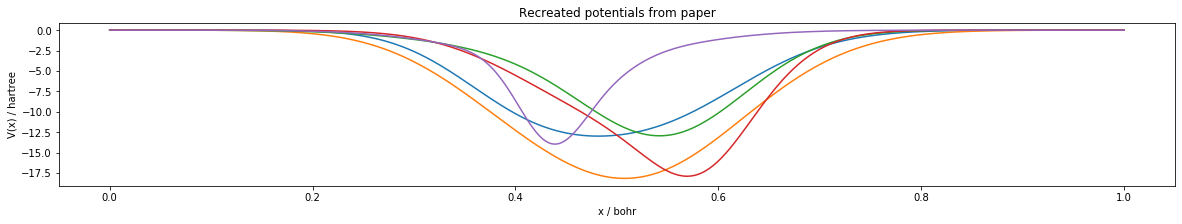

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

preview = 5
analysis_dataset_size = 100
figsize = (20, 3)
dpi = None

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(potential)[:, :preview]) # only plot first potentials
plt.title("Recreated potentials from paper")
plt.xlabel("x / bohr")
plt.ylabel("V(x) / hartree")
plt.show()

## Recreate Sample Potential

In [6]:
# parameters were found by gradient descent
a = [4.02480191, 5.99455501, 10.76801402]
b = [0.52157438, 0.58645736, 0.57318963]
c = [0.07131018, 0.03986175, 0.05540802]

a = np.array(a)[np.newaxis, np.newaxis, :]
b = np.array(b)[np.newaxis, np.newaxis, :]
c = np.array(c)[np.newaxis, np.newaxis, :]

params['filename'] = "dataset_sample"

potential, x, h = calculate_potentials(a, b, c, **params)
params['h'] = h

tf.keras.backend.clear_session()
energies, wavefunctions = solve_schroedinger(potential, params)

save_dataset(base_dir, params['filename'], params['format'],  x.numpy(), h.numpy(), potential.numpy(), wavefunctions.numpy(), energies.numpy())
print("dataset", params['filename'], "saved to", base_dir)

dataset dataset_sample saved to ../data/recreate


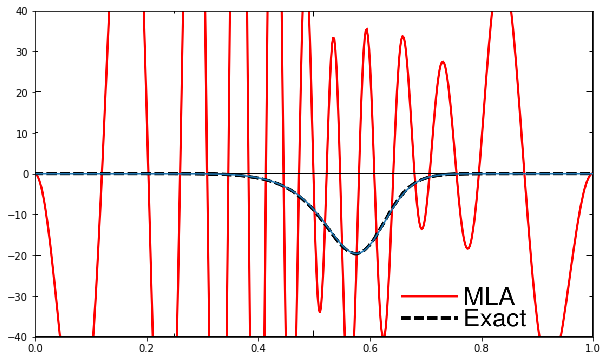

In [7]:
img = plt.imread("1b_sample_potential.png")
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img, extent=[0, 1, -40, 40])
plt.axis('auto')
plt.plot(x, np.transpose(potential))
plt.show()